# Heart Attack Data Analysis & Prediction

In [1]:
!pip install lazypredict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

def modify_description(description):
    modified_description = description.capitalize() 
    return modified_description

feat_info_dict = {
    'Age': 'Age of the patient',
    'Sex': 'Sex of the patient',
    'exang': 'exercise induced angina (1 = yes; 0 = no)',
    'caa': 'number of major vessels (0-3)',
    'cp': 'Chest Pain type',
    'chestpaintype1': 'typical angina',
    'chestpaintype2': 'atypical angina',
    'chestpaintype3': 'non-anginal pain',
    'chestpaintype4': 'asymptomatic',
    'trtbps': 'resting blood pressure (in mm Hg)',
    'chol': 'cholestoral in mg/dl fetched via BMI sensor',
    'fbs': '(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)',
    'rest_ecg': 'resting electrocardiographic results',
    'Value 0': 'normal (resting electrocardiographic result)',
    'Value 1': 'abnormal (ST-T wave abnormality)',
    'Value 2': "abnormal (probable or definite left ventricular hypertrophy by Estes' criteria)",
    'thalach': 'maximum heart rate achieved',
    'target': '0= less chance of heart attack 1= more chance of heart attack'
}

# Apply writing rules to modify descriptions
modified_feat_info_dict = {key: modify_description(value) for key, value in feat_info_dict.items()}

# Rename 'Value 0', 'Value 1', 'Value 2'
modified_feat_info_dict['electrocardiographictype1'] = modified_feat_info_dict.pop('Value 0')
modified_feat_info_dict['electrocardiographictype2'] = modified_feat_info_dict.pop('Value 1')
modified_feat_info_dict['electrocardiographictype3'] = modified_feat_info_dict.pop('Value 2')

# Separate 'cp', 'rest_ecg', and other features
cp_data = [('cp', key, value) for key, value in modified_feat_info_dict.items() if 'chestpaintype' in key]
rest_ecg_data = [('rest_ecg', key, value) for key, value in modified_feat_info_dict.items() if 'electrocardiographictype' in key]
other_data = [('other', key, value) for key, value in modified_feat_info_dict.items() if 'chestpaintype' not in key and 'electrocardiographictype' not in key]

# Create MultiIndex DataFrames
cp_df = pd.DataFrame(cp_data, columns=['Level 1', 'Level 2', 'Description']).set_index(['Level 1', 'Level 2'])
rest_ecg_df = pd.DataFrame(rest_ecg_data, columns=['Level 1', 'Level 2', 'Description']).set_index(['Level 1', 'Level 2'])
other_df = pd.DataFrame(other_data, columns=['Level 1', 'Feature', 'Description']).set_index(['Level 1', 'Feature'])

# Concatenate DataFrames
feat_info_df = pd.concat([cp_df, rest_ecg_df, other_df])

# Display DataFrame
html_table = feat_info_df.to_html(classes='dataframe', border=1, index_names=False)
display(HTML(html_table))


In [4]:
heart_disease = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')

In [5]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
heart_disease.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
heart_disease.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Before exploratory data analysis we'd better make couple of feature engineering.

 <img src="https://i.hizliresim.com/jtrgvif.png" alt="Image Alt Text">


In [8]:
cp = pd.get_dummies(heart_disease['cp'],prefix='electrocardiographic')
restecg = pd.get_dummies(heart_disease['restecg'],prefix='restecg_type')
heart_disease = pd.concat([restecg,cp,heart_disease],axis=1)

In [9]:
dummy_cols= ['restecg_type_0', 'restecg_type_1', 'restecg_type_2',
       'electrocardiographic_0', 'electrocardiographic_1',
       'electrocardiographic_2', 'electrocardiographic_3']

In [10]:
def dummy_conv(value):
    if value==True:
        return 1
    else:
        return 0
for col in dummy_cols:
    heart_disease[col] = heart_disease[col].apply(dummy_conv)
heart_disease.drop(columns=['restecg','cp'],inplace=True)

<img src="https://i.hizliresim.com/8xyvij8.png" alt="Image Alt Text">


Text(0.5, 1.0, 'Correlation of features with heart attack')

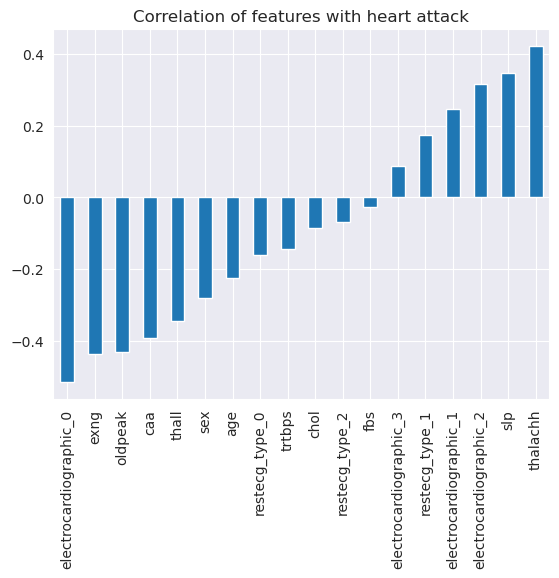

In [11]:
sns.set_style('darkgrid')
heart_disease.corr()['output'].sort_values()[:-1].plot(kind='bar')
plt.title('Correlation of features with heart attack')

<Figure size 1500x1300 with 0 Axes>

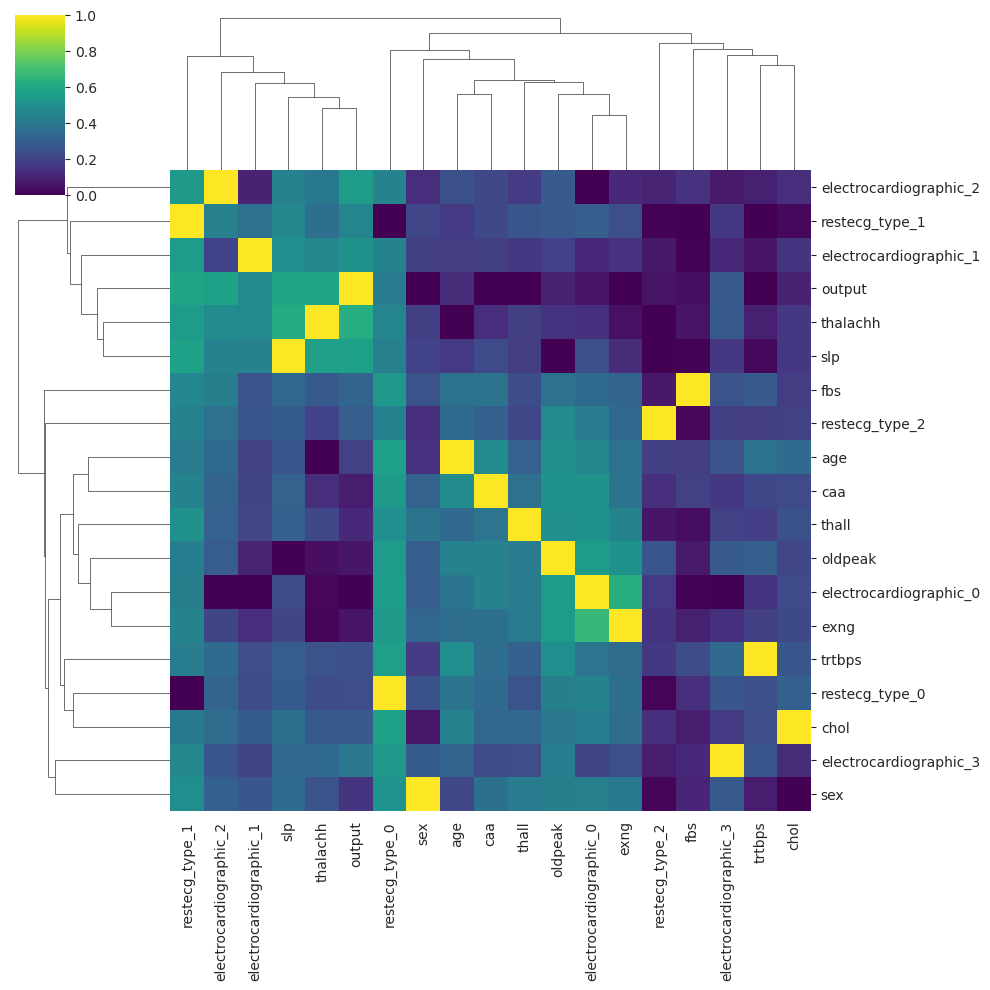

In [12]:
plt.figure(figsize=(15,13))
sns.clustermap(heart_disease.corr(),standard_scale=1,cmap='viridis')

<Axes: xlabel='sex', ylabel='count'>

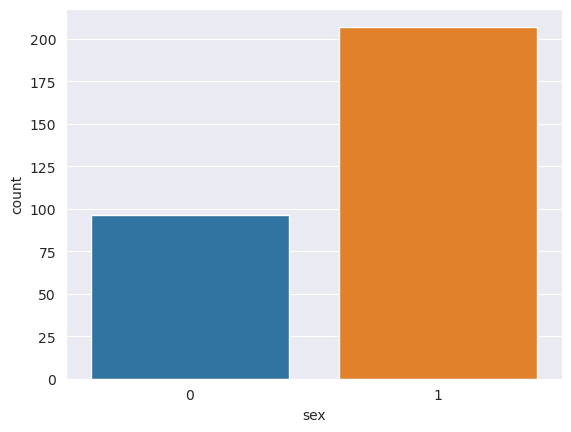

In [13]:
sns.countplot(x='sex',data=heart_disease)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


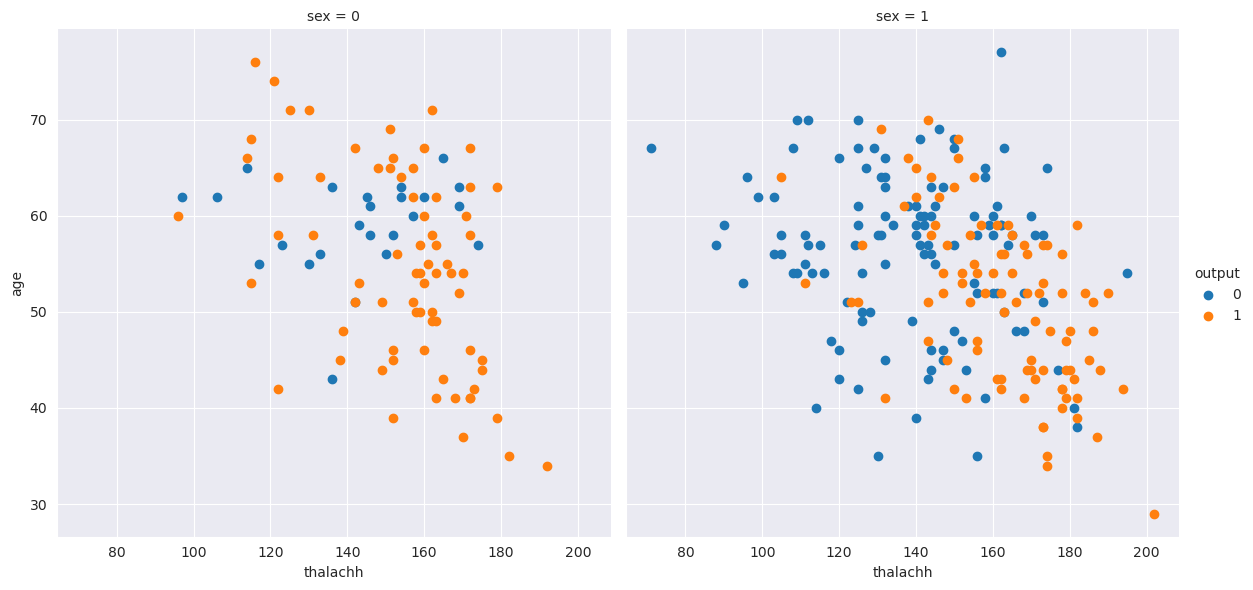

In [14]:
g = sns.FacetGrid(col='sex',data=heart_disease,hue='output',height=6,aspect=1)
g.map(plt.scatter,'thalachh','age')
g.add_legend()

# Heart attack rate is proportional with maximum heart rate according to the plot above. 

/tmp/ipykernel_20/4225887946.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


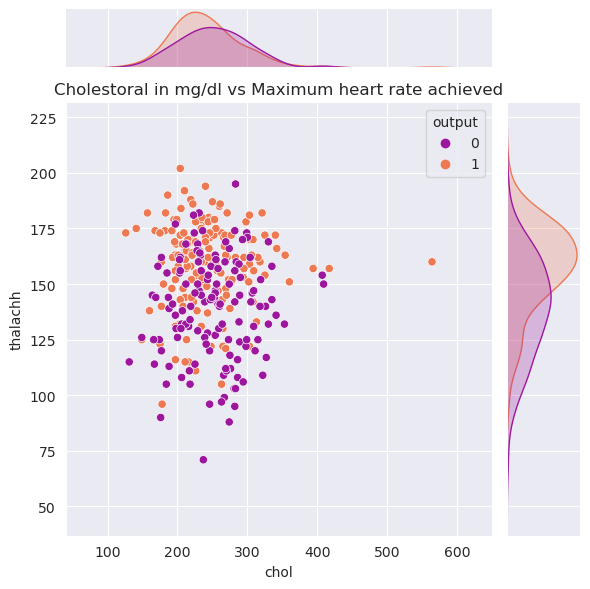

In [15]:
sns.jointplot(x='chol', y='thalachh', data=heart_disease, kind='scatter', palette='plasma',hue='output')
plt.title('Cholestoral in mg/dl vs Maximum heart rate achieved')
plt.tight_layout()

# According to the plot above, the occurrence of heart attacks is highest between cholestoral levels of 200 and 300.

Text(0.5, 1.0, 'Resting blood pressure (in mm hg) vs Cholestoral in mg/dl')

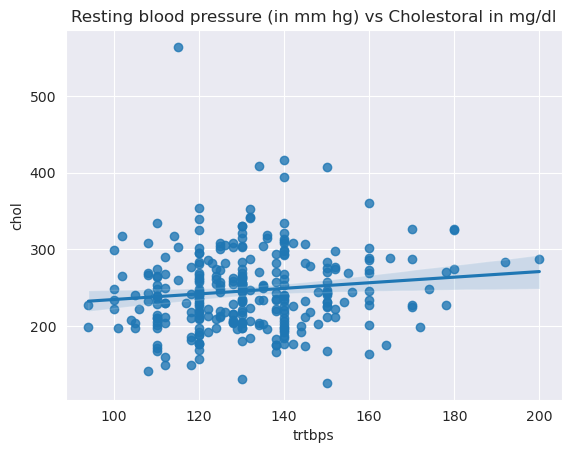

In [16]:
sns.regplot(x='trtbps',y='chol',data=heart_disease)
plt.title('Resting blood pressure (in mm hg) vs Cholestoral in mg/dl')

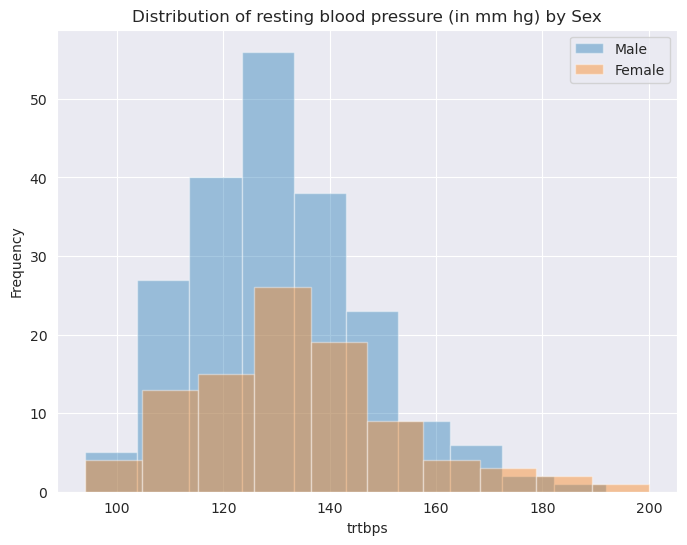

In [17]:
plt.figure(figsize=(8, 6))

heart_disease[heart_disease['sex'] == 1]['trtbps'].plot(kind='hist', alpha=0.4, label='Male')
heart_disease[heart_disease['sex'] == 0]['trtbps'].plot(kind='hist', alpha=0.4, label='Female')

plt.legend()

plt.title('Distribution of resting blood pressure (in mm hg) by Sex')
plt.xlabel('trtbps')
plt.ylabel('Frequency')

plt.show()

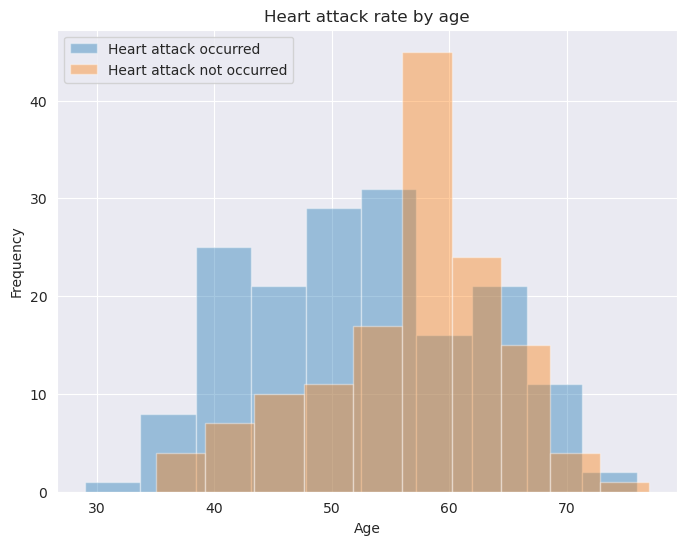

In [18]:
plt.figure(figsize=(8, 6))

heart_disease[heart_disease['output']==1]['age'].plot(kind='hist', alpha=0.4,label='Heart attack occurred')
heart_disease[heart_disease['output']==0]['age'].plot(kind='hist', alpha=0.4,label='Heart attack not occurred')

plt.title('Heart attack rate by age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.show()

  # There is no specific range heart attack occurred according to the plot above. 
 # Let's jump onto Machine Learning section.

 <img src="https://i.hizliresim.com/8fcf5xw.png" alt="Image Alt Text">


In [19]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
X = heart_disease.drop('output',axis=1)
y = heart_disease['output']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 21.56it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.87               0.87     0.87      0.87   
AdaBoostClassifier                 0.81               0.82     0.82      0.81   
NearestCentroid                    0.81               0.81     0.81      0.81   
RandomForestClassifier             0.81               0.81     0.81      0.81   
NuSVC                              0.81               0.81     0.81      0.81   
ExtraTreesClassifier               0.81               0.81     0.81      0.81   
XGBClassifier                      0.80               0.80     0.80      0.80   
PassiveAggressiveClassifier        0.80               0.80     0.80      0.80   
LGBMClassifier                     0.80               0.80     0.80      0.80   
RidgeClassifier                    0.80               0.80     0.80      0.80   
LinearDiscriminantAnalysis  

# As we can see from the result BernoulliNB model performed the best performance.

# Thank you for your interest in my project.